# <span style="color:green"><center>Diplomado en Big Data</center></span>

# <span style="color:red"><center>Introducción al Procesamiento Paralelo<center></span>

<img src="http://dask.readthedocs.io/en/latest/_images/dask_horizontal.svg"
     align="right"
     width="30%"
     alt="Dask logo\">

# Paralelización con `dask.delayed`

##   <span style="color:blue">Profesores</span>

1. Alvaro Mauricio Montenegro Díaz, ammontenegrod@unal.edu.co
2. Daniel Mauricio Montenegro Reyes, dextronomo@gmail.com 

##   <span style="color:blue">Asesora Medios y Marketing digital</span>
 

4. Maria del Pilar Montenegro, pmontenegro88@gmail.com 

## <span style="color:blue">Contenido</span>

* [Introducción](#Introducción)
* [Bases](Bases)
* [Paralelización usando delayed](#Paralelización-usando-delayed)
* [Ejemplo con Pandas groupby](#Ejemplo-con-Pandas-groupby)
* [Usando decoradores directamente](#Usando-decoradores-directamente)
* [Cerrar el cliente](#Cerrar-el-cliente)

## <span style="color:blue">Introducción</span>

En esta sección paralelizamos el código de estilo de ciclos de ejecución  con Dask y `dask.delayed`. A menudo, esta es la única función que necesitará para convertir funciones y usarlas con Dask.

Esta es una forma sencilla de usar `dask` para paralelizar bases de código existentes o construir [sistemas complejos] (https://blog.dask.org/2018/02/09/credit-models-with-dask). 

Esto también nos ayudará a comprender mejor las secciones posteriores.

** Documentación relacionada **

* [Delayed documentation](https://docs.dask.org/en/latest/delayed.html)
* [Delayed screencast](https://www.youtube.com/watch?v=SHqFmynRxVU)
* [Delayed API](https://docs.dask.org/en/latest/delayed-api.html)
* [Delayed examples](https://examples.dask.org/delayed.html)
* [Delayed best practices](https://docs.dask.org/en/latest/delayed-best-practices.html)

In [1]:
from dask.distributed import Client

client = Client(n_workers=4)

## <span style="color:blue">Bases</span>

Primero hagamos algunas funciones de juguete, `inc` y` add`, que duerman un rato para simular el trabajo. Luego, ejecutaremos estas funciones normalmente.

En la siguiente sección, paralelizaremos este código.

In [3]:
from time import sleep

def inc(x):
    sleep(1)
    return x+1

def add(x, y):
    sleep(1)
    return(x+y)


Calculamos el tiempo de ejecución de este código normal usando el comando mágico `%% time`, que es una función especial del Jupyter Notebook.

In [4]:
%%time
# esto debe tomar 3 segundos para correr debido a que
# llamamos cada función de manera secuencial, una después de la otra.

x = inc(1)
y = inc(3)
z = add(x, y)

CPU times: user 313 ms, sys: 43.8 ms, total: 357 ms
Wall time: 3 s


## <span style="color:blue">Paralelización usando dask.delayed</span>

Esas dos llamadas de incremento se pueden llamar en paralelo, porque son totalmente independientes entre sí.

Transformaremos las funciones *inc* y *add* usando la función `dask.delayed`. Cuando llamamos a la versión retrasada pasando los argumentos, exactamente como antes, la función original todavía no se llama, por lo que la ejecución de la celda finaliza muy rápidamente. En su lugar, se crea un objeto retrasado, que realiza un seguimiento de la función a llamar y los argumentos que se le pasan.

In [6]:
from dask import delayed

In [7]:
%%time

# Esto corre inmediatamente, todo lo que hace es construir un grafo
x = delayed(inc)(1)
y = delayed(inc)(2)
z = delayed(add)(x,y)

CPU times: user 2.25 ms, sys: 0 ns, total: 2.25 ms
Wall time: 3 ms


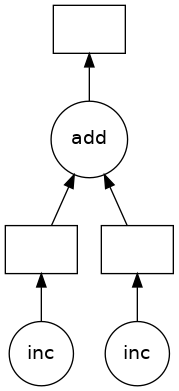

In [8]:
z.visualize()

Esto se ejecutó de inmediato, ya que todavía no ha sucedido nada.

Para obtener el resultado, llame a compute. Tenga en cuenta que esto se ejecuta más rápido que el código original.

In [9]:
%%time
# Esto realmente ejecuta nuestro cálculo usando un grupo de subprocesos local

z.compute()

CPU times: user 236 ms, sys: 38 ms, total: 274 ms
Wall time: 2.05 s


5

In [8]:
z

Delayed('add-0e2f2a8f-1ed3-453f-af6c-aa94034ca36a')

### ¿Lo que acaba de suceder?

El objeto z es un objeto `Delayed`. Este objeto contiene todo lo que necesitamos para calcular el resultado final, incluidas las referencias a todas las funciones que se requieren y sus entradas y la relación entre sí. 

Podemos evaluar el resultado con *.compute ()* como arriba o podemos visualizar el gráfico de tareas para este valor con *.visualize ()*.

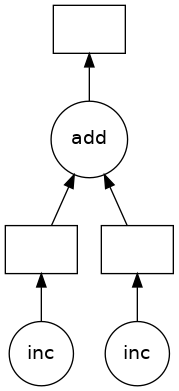

In [7]:
z.visualize()

Observe que esto incluye los nombres de las funciones anteriores y el flujo lógico de las salidas de las funciones inc a las entradas de add.

### Algunas preguntas a considerar:

+ ¿Por qué pasamos de 3 a 2? 
+ ¿Por qué no pudimos paralelizar hasta 1s?
+ ¿Qué hubiera sucedido si las funciones inc y add no incluyeran sleep (1)? 
+ ¿Dask aún podría acelerar este código?
+ ¿Qué pasa si tenemos múltiples salidas o también queremos tener acceso a x o y?

### Ejercicio: paralelizar un bucle for

Los bucles *for* son una de las cosas más comunes que queremos paralelizar. Utilice `dask.delayed` en *inc* y *sum* para paralelizar el cálculo a continuación:

In [11]:
data = [1,2,3,4,5,6,7,8]

In [12]:
%%time
# código secuencial

results = []
for x in data:
    y = inc(x)
    results.append(y)
    
total = sum(results)

CPU times: user 803 ms, sys: 150 ms, total: 953 ms
Wall time: 8.01 s


### Una Solución

In [10]:
%%time
# código paralelo

CPU times: user 5 µs, sys: 1e+03 ns, total: 6 µs
Wall time: 13.4 µs


In [13]:
%%time
results = []

for x in data:
    y = delayed(inc)(x)
    results.append(y)
    
total = delayed(sum)(results)
print('Antes de calcular', total)  # Let's see what type of thing total is
result = total.compute()
print('Después de calcular', result)  # After it's computed


Antes de calcular Delayed('sum-ac76d535-cebf-4f11-9b7c-c8cda0e6522a')
Después de calcular 44
CPU times: user 245 ms, sys: 31.4 ms, total: 276 ms
Wall time: 2.09 s


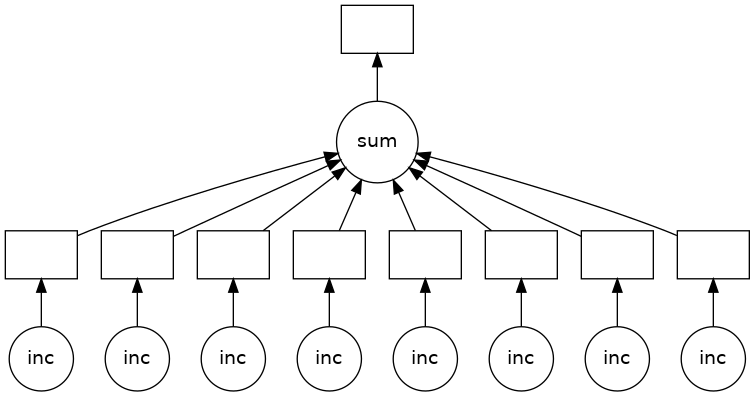

In [12]:
total.visualize()

In [22]:
delayed(inc)(1) + delayed(inc)(2)

Delayed('add-2e5ec304909e34a37d03f5e7c94ea0e1')

### Ejercicio: paralelización de un código de bucle for con flujo de control

A menudo queremos retrasar solo algunas funciones, ejecutando algunas de ellas inmediatamente. Esto es especialmente útil cuando esas funciones son rápidas y nos ayudan a determinar qué otras funciones más lentas debemos llamar. Esta decisión, de retrasar o no retrasar, suele ser donde debemos ser reflexivos al utilizar *dask.delayed*.

En el siguiente ejemplo, iteramos a través de una lista de entradas. Si esa entrada es par, entonces queremos llamar a *inc*. Si la entrada es impar, queremos llamar a *doble*. Esta  función de decisión *is_even* para llamar  *inc* o *double* debe tomarse de inmediato (no de manera perezosa) para que el código Python de creación de nuestro gráfo continúe.

In [12]:
def double(x):
    sleep(1)
    return 2*x

def is_even(x):
    return not x%2

data = [1,2,3,4,5,6,7,8,9,10]

In [13]:
%%time
# código secuencial

results = []
for x in data:
    if is_even(x):
        y = inc(x)
    else:
        y = double(x)
    results.append(y)
    
total = sum(results)
print(results)
print(total)

[2, 3, 6, 5, 10, 7, 14, 9, 18, 11]
85
CPU times: user 1.01 s, sys: 120 ms, total: 1.13 s
Wall time: 10 s


In [16]:
%%time
# código paralelo


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 10 µs


In [16]:
results = []
for x in data:
    if is_even(x):
        y = delayed(inc)(x)
    else:
        y = delayed(double)(x)
    results.append(y)

total = delayed(sum)(results)


In [18]:
%time total.compute()

CPU times: user 257 ms, sys: 63.6 ms, total: 320 ms
Wall time: 3.06 s


85

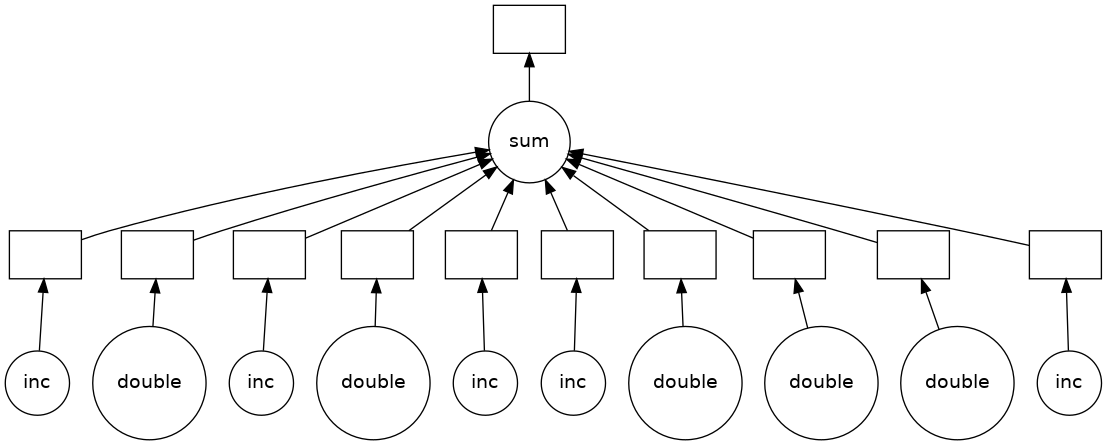

In [17]:
total.visualize()

## <span style="color:blue">Ejemplo con Pandas groupby</span>

Paralelización de  un reducción *groupby* de Pandas

En este ejercicio leemos varios archivos CSV y realizamos una operación *groupby* en paralelo. Se da un código secuencial para hacer esto y lo paralelizamos con *dask.delayed*.

El cálculo que paralelizaremos es calcular el retraso medio de salida por aeropuerto a partir de algunos datos históricos de vuelo. Haremos esto usando *dask.delayed* junto con Pandas. En una sección futura haremos este mismo ejercicio con  `dask.dataframe`.

### Crear datos

Ejecute este código para preparar algunos datos.

Este código descarga y extrae algunos datos históricos de vuelos fuera de Nueva York entre 1990 y 2000. Los datos son originalmente de [ASA](http://stat-computing.org/dataexpo/2009/the-data.html).

In [21]:
!pyhton prep.py -d flights

o 

In [ ]:
%run prep.py -d flights

### Inspección de los datos

In [14]:
import os
sorted(os.listdir(os.path.join('../data', 'nycflights')))

['1990.csv',
 '1991.csv',
 '1992.csv',
 '1993.csv',
 '1994.csv',
 '1995.csv',
 '1996.csv',
 '1997.csv',
 '1998.csv',
 '1999.csv']

Lee un archivo con `pandas.read_csv` y calcula la media de las demoras en salida de vuelos


In [18]:
import pandas as pd
df = pd.read_csv(os.path.join('../data', 'nycflights', '1990.csv'))
df.head()

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
0,1990,1,1,1,1621.0,1540,1747.0,1701,US,33,...,NaN,46.0,41.0,EWR,PIT,319.0,NaN,NaN,0,0
1,1990,1,2,2,1547.0,1540,1700.0,1701,US,33,...,NaN,-1.0,7.0,EWR,PIT,319.0,NaN,NaN,0,0
2,1990,1,3,3,1546.0,1540,1710.0,1701,US,33,...,NaN,9.0,6.0,EWR,PIT,319.0,NaN,NaN,0,0
3,1990,1,4,4,1542.0,1540,1710.0,1701,US,33,...,NaN,9.0,2.0,EWR,PIT,319.0,NaN,NaN,0,0
4,1990,1,5,5,1549.0,1540,1706.0,1701,US,33,...,NaN,5.0,9.0,EWR,PIT,319.0,NaN,NaN,0,0


In [28]:
# What is the schema?
df.dtypes

Year                   int64
Month                  int64
DayofMonth             int64
DayOfWeek              int64
DepTime              float64
CRSDepTime             int64
ArrTime              float64
CRSArrTime             int64
UniqueCarrier         object
FlightNum              int64
TailNum              float64
ActualElapsedTime    float64
CRSElapsedTime         int64
AirTime              float64
ArrDelay             float64
DepDelay             float64
Origin                object
Dest                  object
Distance             float64
TaxiIn               float64
TaxiOut              float64
Cancelled              int64
Diverted               int64
dtype: object

In [29]:
# What originating airports are in the data?
df.Origin.unique()

array(['EWR', 'LGA', 'JFK'], dtype=object)

In [30]:
# Mean departure delay per-airport for one year
df.groupby('Origin').DepDelay.mean()

Origin
EWR     9.168411
JFK    11.857274
LGA     8.560045
Name: DepDelay, dtype: float64

### Código secuencial : Mean Departure Delay Per Airport

The above cell computes the mean departure delay per-airport for one year. Here we expand that to all years using a sequential for loop.

In [15]:
from glob import glob
filenames = sorted(glob(os.path.join('../data', 'nycflights', '*.csv')))

In [16]:
filenames

['../data/nycflights/1990.csv',
 '../data/nycflights/1991.csv',
 '../data/nycflights/1992.csv',
 '../data/nycflights/1993.csv',
 '../data/nycflights/1994.csv',
 '../data/nycflights/1995.csv',
 '../data/nycflights/1996.csv',
 '../data/nycflights/1997.csv',
 '../data/nycflights/1998.csv',
 '../data/nycflights/1999.csv']

In [19]:
%%time

sums = []
counts = []
for fn in filenames:
    # Read in file
    df = pd.read_csv(fn)
    
    # Groupby origin airport
    by_origin = df.groupby('Origin')
    
    # Sum of all departure delays by origin
    total = by_origin.DepDelay.sum()
    
    # Number of flights by origin
    count = by_origin.DepDelay.count()
    
    # Save the intermediates
    sums.append(total)
    counts.append(count)

# Combine intermediates to get total mean-delay-per-origin
total_delays = sum(sums)
n_flights = sum(counts)
mean = total_delays / n_flights

CPU times: user 9.4 s, sys: 874 ms, total: 10.3 s
Wall time: 13 s


In [21]:
counts

[Origin
 EWR    115895
 JFK     46803
 LGA    104947
 Name: DepDelay, dtype: int64,
 Origin
 EWR    112234
 JFK     41832
 LGA    100882
 Name: DepDelay, dtype: int64,
 Origin
 EWR    113801
 JFK     42030
 LGA    101553
 Name: DepDelay, dtype: int64,
 Origin
 EWR    110286
 JFK     41280
 LGA    101122
 Name: DepDelay, dtype: int64,
 Origin
 EWR    112516
 JFK     42243
 LGA     98571
 Name: DepDelay, dtype: int64,
 Origin
 EWR    106398
 JFK     45412
 LGA     96810
 Name: DepDelay, dtype: int64,
 Origin
 EWR    114019
 JFK     42688
 LGA     92367
 Name: DepDelay, dtype: int64,
 Origin
 EWR    118228
 JFK     39246
 LGA     94042
 Name: DepDelay, dtype: int64,
 Origin
 EWR    116028
 JFK     41865
 LGA     91025
 Name: DepDelay, dtype: int64,
 Origin
 EWR    120046
 JFK     43844
 LGA     92948
 Name: DepDelay, dtype: int64]

In [39]:
type(sums[0])

pandas.core.series.Series

In [43]:
sums[0].axes

[Index(['EWR', 'JFK', 'LGA'], dtype='object', name='Origin')]

In [41]:
sums[0].describe

<bound method NDFrame.describe of Origin
EWR    1062573.0
JFK     554956.0
LGA     898351.0
Name: DepDelay, dtype: float64>

### Parallelización del código anterior

Usaremos `dask.delayed` para paralelizar el código anterior.  Necesitamos saber algunas cosas extras.

1.  Los métodos y el acceso a los atributos en los objetos retrasados funcionan automáticamente, por lo que si tiene un objeto retrasado, puede realizar operaciones aritméticas, segmentadas y de métodos normales en él y producirá las llamadas retrasadas correctas.

    ```python
    x = delayed(np.arange)(10)
    y = (x + 1)[::2].sum()  # everything here was delayed
    ```
2.  Llamar al método `.compute ()` funciona bien cuando tiene una única salida. Cuando tenga varias salidas, es posible que desee utilizar la función `dask.compute`:

    ```python
    >>> from dask import compute
    >>> x = delayed(np.arange)(10)
    >>> y = x ** 2
    >>> min_, max_ = compute(y.min(), y.max())
    >>> min_, max_
    (0, 81)
    ```
    
    De esta forma Dask puede compartir los valores intermedios (como `y = x**2`)
    
Entonces, nuestro objetivo es paralelizar el código anterior (que se ha copiado a continuación) usando `dask.delayed`. También es posible que se desee visualizar un poco del cálculo para ver si lo está haciendo correctamente.

In [44]:
from dask import compute

In [45]:
%%time

# copied sequential code

sums = []
counts = []
for fn in filenames:
    # Read in file
    df = pd.read_csv(fn)
    
    # Groupby origin airport
    by_origin = df.groupby('Origin')
    
    # Sum of all departure delays by origin
    total = by_origin.DepDelay.sum()
    
    # Number of flights by origin
    count = by_origin.DepDelay.count()
    
    # Save the intermediates
    sums.append(total)
    counts.append(count)

# Combine intermediates to get total mean-delay-per-origin
total_delays = sum(sums)
n_flights = sum(counts)
mean = total_delays / n_flights

CPU times: user 7.14 s, sys: 459 ms, total: 7.6 s
Wall time: 7.07 s


In [46]:
mean

Origin
EWR    10.295469
JFK    10.351299
LGA     7.431142
Name: DepDelay, dtype: float64

In [ ]:
%%time
# your code here

If you load the solution, add `%%time` to the top of the cell to measure the running time.

In [47]:
%%time

# This is just one possible solution, there are
# several ways to do this using `delayed`

sums = []
counts = []
for fn in filenames:
    # Read in file
    df = delayed(pd.read_csv)(fn)

    # Groupby origin airport
    by_origin = df.groupby('Origin')

    # Sum of all departure delays by origin
    total = by_origin.DepDelay.sum()

    # Number of flights by origin
    count = by_origin.DepDelay.count()

    # Save the intermediates
    sums.append(total)
    counts.append(count)

# Compute the intermediates
sums, counts = compute(sums, counts)

# Combine intermediates to get total mean-delay-per-origin
total_delays = sum(sums)
n_flights = sum(counts)
mean = total_delays / n_flights

CPU times: user 632 ms, sys: 91.1 ms, total: 723 ms
Wall time: 4.3 s


In [48]:
# ensure the results still match
mean

Origin
EWR    10.295469
JFK    10.351299
LGA     7.431142
Name: DepDelay, dtype: float64

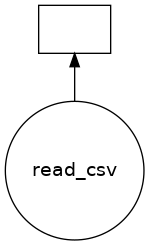

In [55]:
df.visualize()

### Algunas preguntas a considerar:

- ¿Cuánta aceleración obtuviste? ¿Es esta la cantidad de aceleración que esperarías?
- Experimente con dónde llamar a "compute". ¿Qué sucede cuando lo llamas en "sumas" y "recuentos"? ¿Qué pasa si esperas y lo llamas en "mean"?
- Experimente retrasando la llamada a "sum". ¿Cómo se ve el gráfico si se retrasa "suma"? ¿Cómo se ve el gráfico si no lo es?
- ¿Puedes pensar en alguna razón por la que querrías hacer la reducción de una forma sobre la otra?

### Aprende más

Visite la [documentación retrasada] (https://docs.dask.org/en/latest/delayed.html). En particular, este [screencast retrasado] (https://www.youtube.com/watch?v=SHqFmynRxVU) reforzará los conceptos que aprendió aquí y las [mejores prácticas retrasadas] (https://docs.dask.org/ en / latest / delayed-best-practices.html) recopila consejos sobre el uso correcto de `dask.delayed`.

## <span style="color:blue">Usando decoradores directamente</span>

In [56]:
import dask

@dask.delayed
def inc(x):
    return x + 1

@dask.delayed
def double(x):
    return x * 2

@dask.delayed
def add(x, y):
    return x + y

data = [1, 2, 3, 4, 5]

output = []
for x in data:
    a = inc(x)
    b = double(x)
    c = add(a, b)
    output.append(c)

total = dask.delayed(sum)(output)

In [57]:
total.compute()

50

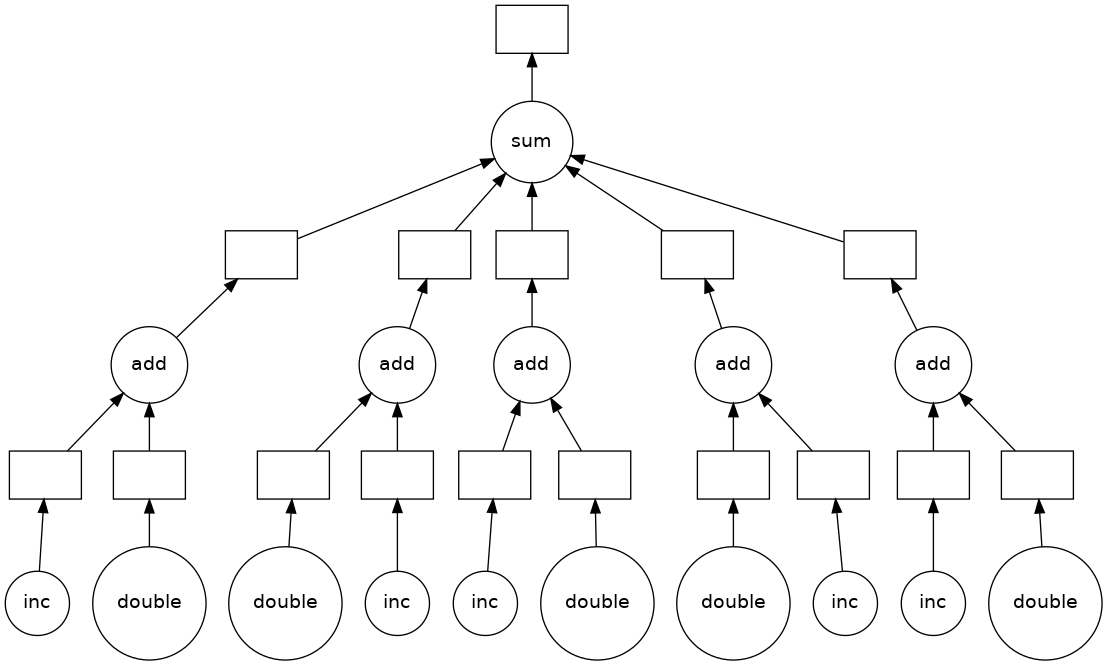

In [58]:
total.visualize()

## <span style="color:blue">Cerrar el cliente</span>

Before moving on to the next exercise, make sure to close your client or stop this kernel.

In [49]:
client.close()